In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(precision=2)

In [3]:
X = np.random.rand(500, 50) + np.random.randn(500, 50)*0.2
X[:,0] = 1.

In [4]:
beta = np.random.randn(50)*5
idx = np.random.randint(0, 50, size=20)
beta[idx] = 0.
print(beta)

[  0.     6.96   0.     0.     0.06  -8.22  -3.59  -7.49  -0.49  -8.97
   0.29  -6.04  -8.75   2.86   0.     0.   -10.42   0.     0.2   -2.14
  -0.08   1.47   0.    -5.14   0.    -6.95   2.47   0.     0.     0.
   0.    10.09  -8.18  -1.79   0.     8.47   0.     3.7   -0.33   0.
  -2.98   2.84  -2.57  -1.32   0.     6.8   -4.23   2.53  -3.02   0.  ]


In [5]:
y = X.dot(beta) + np.random.randn(500)*10.

In [6]:
def step(Q, R, X, y, feature):
    H = Q.dot(Q.T)
    feature_vec = X[:,feature]
    feature_vec_sign = feature_vec - H.dot(feature_vec)
    alpha = np.linalg.norm(feature_vec_sign)
    feature_vec_sign /= alpha
    R_next = np.column_stack([np.row_stack([R, np.zeros(R.shape[1])]),
                              np.concatenate([Q.T.dot(feature_vec), [alpha]])])
    Q_next = np.column_stack([Q, feature_vec_sign])
    H_next = Q_next.dot(Q_next.T)
    y_hat = H_next.dot(y)
    r = y - y_hat
    rss = np.linalg.norm(r)
    return Q_next, R_next, rss

def move_feature(unused_features, used_features, feature):
    unused_features.remove(feature)
    used_features.append(feature)

def init_QR_rss(X, y):
    f = X[:,0]
    alpha = np.linalg.norm(f)
    Q = X[:, 0:1] / alpha
    R = np.array([[alpha]])
    H = Q.dot(Q.T)
    y_hat = H.dot(y)
    r = y - y_hat
    rss = np.linalg.norm(r)
    return Q, R, rss

def get_coeff_string(beta, feature):
    if beta is not None:
        coeff_string = f" [true value: {beta[feature]:.2f}]"
    else:
        coeff_string = ""
    return coeff_string

def forward_stepwise_regression(X, y, beta=None):
    N, p = X.shape
    unused_features = list(range(p))
    used_features = []
    rss_list = []

    print("step 0.")
    coeff_string = get_coeff_string(beta, 0)
    print(f"  feature: 0 (intercept){coeff_string}")
    move_feature(unused_features, used_features, 0)
    Q, R, rss = init_QR_rss(X, y)
    rss_list.append(rss)
    print(f"  RSS: {rss}")
    for i in range(1, p):
        print(f"step {i}.")
        best_rss_drop = -1
        best_feature = -1
        for feature in unused_features:
            _, _, rss_ = step(Q, R, X, y, feature)
            rss_drop = rss - rss_
            if rss_drop > best_rss_drop:
                best_rss_drop = rss_drop
                best_feature = feature
        move_feature(unused_features, used_features, best_feature)
        Q, R, rss = step(Q, R, X, y, best_feature)
        rss_list.append(rss)
        coeff_string = get_coeff_string(beta, best_feature)
        print(f"  feature: {best_feature}{coeff_string}")
        print(f"  RSS: {rss}")
    return rss_list

In [7]:
rss_list = forward_stepwise_regression(X, y, beta)

step 0.
  feature: 0 (intercept) [true value: 0.00]
  RSS: 324.3850739629595
step 1.
  feature: 31 [true value: 10.09]
  RSS: 308.3578163412387
step 2.
  feature: 9 [true value: -8.97]
  RSS: 297.7647029696203
step 3.
  feature: 5 [true value: -8.22]
  RSS: 289.50252806531734
step 4.
  feature: 16 [true value: -10.42]
  RSS: 281.9550513753176
step 5.
  feature: 25 [true value: -6.95]
  RSS: 274.48906002507954
step 6.
  feature: 35 [true value: 8.47]
  RSS: 267.6640569540273
step 7.
  feature: 45 [true value: 6.80]
  RSS: 260.71253507822195
step 8.
  feature: 12 [true value: -8.75]
  RSS: 254.76686052333199
step 9.
  feature: 1 [true value: 6.96]
  RSS: 248.92662146696998
step 10.
  feature: 11 [true value: -6.04]
  RSS: 244.42442404725423
step 11.
  feature: 32 [true value: -8.18]
  RSS: 240.04920122463906
step 12.
  feature: 19 [true value: -2.14]
  RSS: 235.63177211550163
step 13.
  feature: 7 [true value: -7.49]
  RSS: 231.2936076017289
step 14.
  feature: 46 [true value: -4.23]
  R

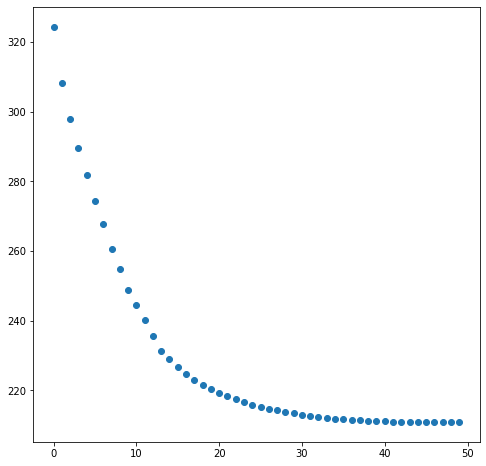

In [8]:
plt.figure(figsize=(8,8))
plt.scatter(range(len(rss_list)), rss_list)